<a href="https://colab.research.google.com/github/stranghr/Python/blob/main/LearnigML_CNN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.optim as optim
import torchvision
from tqdm.notebook import tqdm



In [ ]:
!nvidia-smi
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Thu May 15 06:52:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


transform_train = transforms.Compose([
   transforms.RandomCrop(32,padding=4), transforms.RandomHorizontalFlip(p=1.0),transforms.ToTensor(),
   transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

cifar10_train = datasets.CIFAR10(root='../Data/', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size = 128, shuffle=True)

cifar10_val = datasets.CIFAR10(root='../Data/', train=False, download=True, transform=transform_train)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size = 128)



100%|██████████| 170M/170M [00:04<00:00, 34.9MB/s]


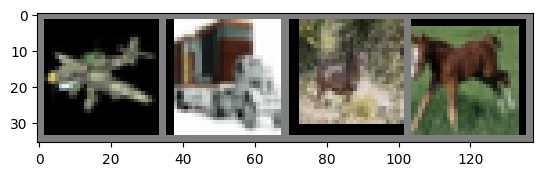

TypeError: unsupported format string passed to list.__format__

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))
#print(' '.join(f'{[labels[j]]:5s}'for j in range(4)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.fc3 = nn.Linear(in_features=84, out_features=10)

  def forward(self, x): #dimenstion : 3,32,32
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()
device = 'cuda'
model = Net()
model = model.to(device)
print(model)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
class VGG(nn.Module):
  def __init__(self, config, num_classes=10):
    super(VGG, self).__init__()
    self.features = self.make_layer(config)
    self.classifier = nn.Sequential(
        nn.Dropout(0.5), #과적합방지
        nn.Linear(512, 512),
        nn.ReLU(True),
        nn.Dropout(0.5),
        nn.Linear(512,512),
        nn.ReLU(True),
        nn.Linear(512, num_classes)
    )
  def forward(self, x):
    out = self.features(x)
    out = torch.flatten(out, start_dim=1)
    out = self.classifier(out)
    return out
  def make_layer(self,config):
    layers = []
    in_planes = 3
    for value in config:
      if value == 'Maxpool':
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
      else:
        layers.append(nn.Conv2d(in_planes, value, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(value))
        layers.append(nn.ReLU(True))
        in_planes = value
    return nn.Sequential(*layers)
channel_list = [64,64,'Maxpool', 128,128,'Maxpool', 256,256,256, 'Maxpool', 512,512,512, 'Maxpool', 512,512,512, 'Maxpool']
device = 'cuda'
model = VGG(channel_list).to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
epochs = 10
lr = 2e-4

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [ ]:
tot_train_loss = []
for e in range(1,epochs+1):
  model.train()
  print(f'=================== Epoch {e}/{epochs} ==================')
  train_loss = 0.0
  for datas, labels in tqdm(train_loader):
    datas = datas.to(device)
    labels = labels.to(device)

    output = model(datas)
    loss = loss_fn(output, labels)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


  tot_train_loss.append(train_loss/len(train_loader))
  print(f'Loss: {train_loss/len(train_loader):.6f}')

  with torch.no_grad():
    model.eval()
    val_acc = 0.0

    for datas, labels in tqdm(val_loader):
      datas = datas.to(device)
      labels = labels.to(device)

      output = model(datas)
      preds = torch.argmax(output, dim=1)
      val_acc += (preds.eq(labels)).sum()

  print(f"[Epoch]{e}, [val Result] {(val_acc/len(val_loader.dataset))*100:.3f}%")

=================== Epoch 1/10 ==================


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 0.340212


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch]1, [val Result] 83.090%
=================== Epoch 2/10 ==================


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 0.312883


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch]2, [val Result] 82.800%
=================== Epoch 3/10 ==================


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 0.283743


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch]3, [val Result] 83.880%
=================== Epoch 4/10 ==================


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 0.264246


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch]4, [val Result] 83.650%
=================== Epoch 5/10 ==================


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 0.247099


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch]5, [val Result] 83.710%
=================== Epoch 6/10 ==================


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 0.223931


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch]6, [val Result] 83.400%
=================== Epoch 7/10 ==================


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 0.211350


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch]7, [val Result] 84.240%
=================== Epoch 8/10 ==================


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 0.195144


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch]8, [val Result] 84.900%
=================== Epoch 9/10 ==================


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 0.184601


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch]9, [val Result] 85.810%
=================== Epoch 10/10 ==================


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 0.174719


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch]10, [val Result] 84.770%


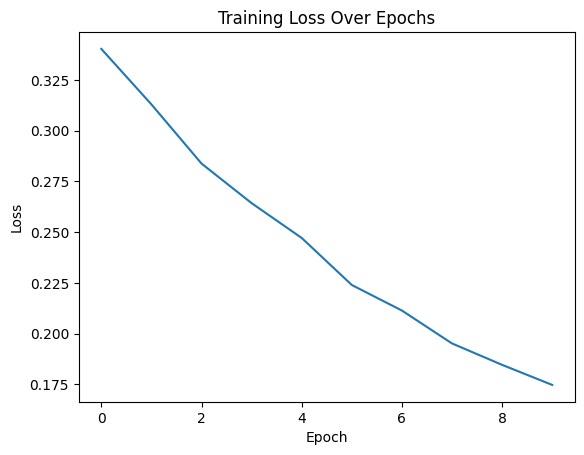

In [ ]:
plt.plot(tot_train_loss)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
classes =  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class_correct= list(0. for i in range(10)) #각클래스별로모델의예측이실제정답과얼마나일치하는지확인하기위한리스트생성
class_total= list(0. for i in range(10)) #각클래스별로전체데이터개수확인을위한리스트생성
with torch.no_grad():
  for data in val_loader:
    images, labels = data[0].to(device), data[1].to(device) # data는image와label을가지고있음
    outputs = model(images)
    _, predicted = torch.max(outputs, 1) # 생성된10개의클래스확률중가장큰값을가진클래스index를반환
    c = (predicted == labels).squeeze() # 모델이예측한index와label의일치/불일치여부판단
    for label in range(10):  # 클래스별맞춘개수를입력하기위한작업
      mask = labels == label # mask가True인경우에만리스트에일치/불일치여부입력(False인경우0)
      class_correct[label] += (c & mask).sum().item()  # 예측도맞고현재보는class(mask)인경우에해당레이블리스트에더해줌
      class_total[label] += mask.sum().item() # 현재보는class(mask)인경우에해당레이블리스트에더해줌
for i in range(10): # 각클래스별로정확도출력
  print(f'Accuracyof {classes[i]}: {100 * class_correct[i] / class_total[i]}%')

Accuracyof plane: 85.9%
Accuracyof car: 94.8%
Accuracyof bird: 80.6%
Accuracyof cat: 74.0%
Accuracyof deer: 82.9%
Accuracyof dog: 71.4%
Accuracyof frog: 92.7%
Accuracyof horse: 91.0%
Accuracyof ship: 91.0%
Accuracyof truck: 86.0%


In [ ]:
torch.save(model.state_dict(), './cifar_net1.pth')


AttributeError: '_IncompatibleKeys' object has no attribute 'state_dict'

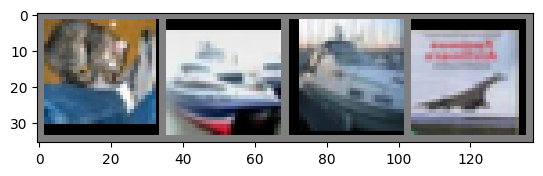

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   ship  ship  plane


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
dataiter = iter(val_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
outputs = model(images.cuda())
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

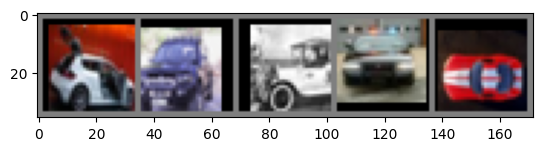

Image  1: Predicted = car, Actual = car
Image  2: Predicted = car, Actual = car
Image  3: Predicted = car, Actual = car
Image  4: Predicted = ship, Actual = car
Image  5: Predicted = car, Actual = car


In [ ]:
car_idx = classes.index('car')
car_images = images[labels == car_idx][:5].to(device)
car_labels = labels[labels == car_idx][:5]

imshow(torchvision.utils.make_grid(car_images.cpu()))

model.eval()
with torch.no_grad():
    outputs = model(car_images)
    _, predicted = outputs.max(1)
for i, (pred, actual) in enumerate(zip(predicted, car_labels)):
    print(f"Image {i+1:>2}: Predicted = {classes[pred]}, Actual = {classes[actual]}")
